# eBay 2021/22 ML Challenge
## K-Means w/Linear Regression

In [1]:
# Library Imports
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from tqdm import tqdm
from sklearn import linear_model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pgeocode     # Postal Code GeoDistance
import pickle

from eBayML_Functions import *

### Setup

In [3]:
# Revision (file saves)
method = 'KM10_Linear'
rev = 4

# Setup File Save Names
dataframe_filename = 'Features/' + method + '_R' + str(rev) + '.pkl'
km_model_filename = 'Models/' + method + '_R' + str(rev) + '_KMeans.sav'
linear_model_filename = 'Models/' + method + '_R' + str(rev)

# Turn of warning prints
pd.options.mode.chained_assignment = None # Turn of setting with copy warning


In [ ]:
# Import data
df_raw = pd.read_csv('Data/eBay_ML_Challenge_Dataset_2021_train.tsv', sep='\t', header=0)
# df_raw = df_raw[0:3000000]
print('Loaded raw data\nSample(n): {}\nColumns(m): {}'.format(df_raw.shape[0],df_raw.shape[1]))

### Feature Extraction

In [ ]:
# Extract Features
df_Feat = feature_extraction(df_raw)

# Mean Imputation
df_Feat = df_Feat[df_Feat.columns.values].fillna(value=df_Feat[df_Feat.columns.values].mean()) 

# Save to 'Features" folder
df_Feat.to_pickle(dataframe_filename)

print('Done and saved! Feature head:')
print(df_Feat.head())

##### Feature Load Option

In [10]:
# Load Features
# df_Feat = pd.read_pickle(dataframe_filename)

# Load and concatenate Colab feature files
dataframe_filename = 'Features/' + method + '_R' + str(rev) + '_1.pkl'
df_Feat_1 = pd.read_pickle(dataframe_filename)
dataframe_filename = 'Features/' + method + '_R' + str(rev) + '_2.pkl'
df_Feat_2 = pd.read_pickle(dataframe_filename)
# dataframe_filename = 'Features/' + method + '_R' + str(rev) + '_3.pkl'
# df_Feat_3 = pd.read_pickle(dataframe_filename)
# dataframe_filename = 'Features/' + method + '_R' + str(rev) + '_4.pkl'
# df_Feat_4 = pd.read_pickle(dataframe_filename)
# dataframe_filename = 'Features/' + method + '_R' + str(rev) + '_5.pkl'
# df_Feat_5 = pd.read_pickle(dataframe_filename)



df_Feat = pd.concat([df_Feat_1,df_Feat_2])#,df_Feat_3,df_Feat_4,df_Feat_5])

print('Loaded raw data\nSample(n): {}\nColumns(m): {}'.format(df_Feat.shape[0],df_Feat.shape[1]))

In [11]:
df_Feat

,Type,Handle,Ship_Method,Ship_Fee,Min,Max,Range,Item_Zip,Buyer_Zip,Dist,Weight,Category,Price,Quantity,Size,Processing_Days,Delivery_Days
0,1.0,3.0,0,0.00,3,5,2,97219,49040,3001.984391,5,13,27.95,1,1,2.0,4.0
1,0.0,2.0,0,3.00,3,5,2,11415,62521,2052.265263,0,0,20.50,1,3,0.0,3.0
2,1.0,1.0,0,4.50,3,5,2,27292,53010,1102.546134,9,1,19.90,1,3,1.0,3.0
3,1.0,1.0,0,0.00,3,5,2,90703,80022,1343.238967,8,1,35.50,1,3,1.0,4.0
4,1.0,1.0,0,0.00,3,5,2,90703,55070,2458.659875,3,1,25.00,1,3,0.0,2.0
5,1.0,1.0,0,0.00,3,5,2,43215,77063,1609.050758,1,3,10.39,1,3,1.0,3.0
6,1.0,1.0,0,0.00,3,5,2,91304,60565,2782.648489,0,11,5.70,1,3,0.0,2.0
7,1.0,1.0,0,2.95,3,5,2,49735,29379,1172.750624,1,1,6.00,1,3,0.0,2.0
8,1.0,4.0,3,0.00,2,8,6,43606,32958,1569.435452,0,18,5.55,1,0,1.0,3.0


### Model Training

In [7]:
# def train_kmeans(df,num_clusters,feature_list,all_feat=False,save_filename=km_model_filename,verbose=True):
#     km = KMeans(n_clusters=num_clusters, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=0)
#     if all_feat: y_km = km.fit_predict(df.loc[:, df.columns != 'Delivery_Days'].values)
#     else: y_km = km.fit_predict(df[feature_list].values)
#     values, counts = np.unique(y_km, return_counts=True)
#     if verbose: print('Done with K-Means {} Clusters\nCounts/Counts: {}'.format(NUM_CLUSTERS,counts))
#     pickle.dump(km, open(save_filename, 'wb'))
#     return km, y_km

# def train_linears(df,num_clusters,cluster_assignments,feature_list,all_feat=False,save_filename=linear_model_filename,verbose=True):
#     linear_models = list()

#     for iClust in tqdm(range(num_clusters), disable=not(verbose)):
#         df_Clust = df[cluster_assignments == iClust]
#         if all_feat: X = df_Clust.loc[:, df_Clust.columns != 'Delivery_Days'].values
#         else: X = df_Clust[feature_list].values
#         y = df_Clust['Delivery_Days'].values
#         linear_models.append(linear_model.LinearRegression(normalize=True))
#         linear_models[iClust].fit(X,y) 
#         pickle.dump(linear_models[iClust], open(save_filename + '_' + str(iClust+1) + '.sav', 'wb'))

#     return linear_models

In [8]:
# Kmeans Training
NUM_CLUSTERS = 16
km_feature_list = ['Type','Ship_Method','Range','Item_Zip','Buyer_Zip','Category','Quantity','Size']
km_model, y_km = train_kmeans(df_Feat,NUM_CLUSTERS,km_feature_list,all_feat = True)


Done with K-Means 16 Clusters
Counts/Counts: [151 102 134  89 156 122 192 142  80 136  94 141 110 116 116 119]


In [9]:
# LinearReg Models Training
linear_feature_list = ['Handle','Ship_Fee','Min','Max','Range','Dist','Weight','Price','Processing_Days']
linear_models = train_linears(df_Feat,NUM_CLUSTERS,y_km,linear_feature_list,all_feat = True)

100%|██████████| 16/16 [00:00<00:00, 135.85it/s]


##### Model Load Option

In [10]:
### Load Models

# km_model = pickle.load(open(km_model_filename, 'rb'))

# linear_models = list()
# for iClust in tqdm(range(6)):
#     linear_models.append(pickle.load(open(linear_model_filename + str(iClust+1) + '.sav', 'rb')))


### Loss Calculation

In [11]:
# def calc_loss(df,km_model,lin_models,km_features,lin_features,all_feat=False,verbose=True):

#     if all_feat: km_predict = km_model.predict(df.loc[:, df.columns != 'Delivery_Days'].values)
#     else: km_predict = km_model.predict(df[km_features].values)

#     predictions = np.empty(df.shape[0])

#     for iClust in range(len(lin_models)):
#         df_Clust = df[km_predict == iClust]
#         if all_feat: X = df_Clust.loc[:, df_Clust.columns != 'Delivery_Days'].values
#         else: X = df_Clust[lin_features].values
#         predictions[km_predict == iClust] = lin_models[iClust].predict(X).astype(int)

#     given_days = df['Delivery_Days'].values
#     error_days = given_days - predictions
#     early = 0.4 * abs(np.multiply(error_days < 0, error_days).sum())
#     late = 0.6 * np.multiply(error_days > 0, error_days).sum()
#     loss = (early + late)/df.shape[0]
#     if verbose: print('Loss is {:.2f}'.format(loss))
#     return loss, predictions 

In [12]:
loss,predictions = calc_loss(df_Feat,km_model,linear_models,km_feature_list,linear_feature_list,all_feat = True)

Loss is 0.63


### Quiz Prediction

In [13]:
# def predict(df,km_model,lin_models,km_features,lin_features,all_feat=False,verbose=True):

#     if all_feat: km_predict = km_model.predict(df.loc[:, df.columns != 'Delivery_Days'].values)
#     else: km_predict = km_model.predict(df[km_features].values)

#     predictions = np.empty(df.shape[0])

#     for iClust in range(len(lin_models)):
#         df_Clust = df[km_predict == iClust]
#         if all_feat: X = df_Clust.loc[:, df_Clust.columns != 'Delivery_Days'].values
#         else: X = df_Clust[lin_features].values
#         predictions[km_predict == iClust] = lin_models[iClust].predict(X).astype(int)

#     return predictions 

# def saveQuiz(df,predictions,filename):
#     df_out =  pd.DataFrame(np.nan, index=df_quiz.index, columns=['record identifier','predicted delivery date']).astype(str)

#     for iRow in tqdm(range(df.shape[0])):
#         payment = datetime.strptime(df.iloc[iRow]['payment_datetime'][:16], '%Y-%m-%d %H:%M') + timedelta(hours = -int(df_quiz.iloc[iRow]['payment_datetime'][-6:-3]))
#         delivery = payment + timedelta(days=predictions[iRow])
#         df_out.at[iRow,'record identifier'] = df_quiz['record_number'][iRow]
#         df_out.at[iRow,'predicted delivery date'] = delivery.strftime('%Y-%m-%d')

#     df_out.to_csv(filename, sep="\t",header=False,index=False, compression= 'gzip')


##### Load and Process

In [14]:
# Predict 
dataframeQuiz_filename = 'Features/' + method + '_Quiz_R' + str(rev) + '.pkl'
results_filename = 'SubDataTrain_Results.tsv.gz'

df_quiz = pd.read_csv('Data/eBay_ML_Challenge_Dataset_2021_quiz.tsv', sep='\t', header=0)
df_Feat_Quiz = feature_extraction(df_quiz)

# Mean Imputation
df_Feat_Quiz = df_Feat_Quiz[df_Feat_Quiz.columns.values].fillna(value=df_Feat_Quiz[df_Feat_Quiz.columns.values].mean()) 

# Save Quiz Features
df_Feat_Quiz.to_pickle(dataframeQuiz_filename)

  0%|          | 81/2500000 [00:00<51:52, 803.12it/s]

Extracting Quiz/Test Features


100%|██████████| 2500000/2500000 [35:03<00:00, 1188.39it/s]


##### Quiz Features Load Option

In [15]:
# Load Features
# df_Feat_Quiz = pd.read_pickle(dataframeQuiz_filename)

##### Predict and Save

In [ ]:
predictions = predict(df_Feat_Quiz,km_model,linear_models,km_feature_list,linear_feature_list,all_feat = True)
results_filename = 'Results.tsv.gz'
saveQuiz(df_quiz,predictions,results_filename)

## Appendix Code

### Feature Engineering

In [ ]:
'''
Analyze a specific column (raw data)
'''

# feature = df.item_price.values

# feature[np.isnan(feature)] = np.nanmean(feature)

# plt.hist(feature, bins=30,range=[0,200]);
# plt.ylabel('Probability')
# plt.xlabel('Data')
# # plt.scatter(range(len(feature)),feature)

# print('Mean :' + str(feature.mean()))
# print('Min :' + str(feature.min()))
# print('Max :' + str(feature.max()))
# print('Median: ' + str(np.median(feature)))
# vals,counts = np.unique(feature, return_counts=True)
# index = np.argmax(counts)
# print('Mode: ' + str(vals[index]))

In [ ]:
'''
Analyze a specific feature (processed data)
'''

# feature = df_Feat.Price.values

# plt.hist(feature, bins=30);
# plt.ylabel('Value')
# plt.xlabel('Value')
# # plt.scatter(range(len(feature)),feature)

# print('Mean :' + str(feature.mean()))
# print('Min :' + str(feature.min()))
# print('Max :' + str(feature.max()))
# print('Median: ' + str(np.median(feature)))
# vals,counts = np.unique(feature, return_counts=True)
# index = np.argmax(counts)
# print('Mode: ' + str(vals[index]))

### Parameter Optimization

In [ ]:
'''
K-Means Optimization: Distortion Plot
'''
# distortions1 = []
# distortions2 = []
# differences = []
# clusters_sizes = range(2,23,2)
# for i in tqdm(clusters_sizes):
#     km = KMeans(
#         n_clusters=i, init='random',
#         n_init=10, max_iter=300,
#         tol=1e-04, random_state=0
#     )
#     km.fit(df_Feat.values)
#     distortions1.append(km.inertia_)
#     km.fit(df_Feat[['Type','Ship_Method','Range','Item_Zip','Buyer_Zip','Category','Quantity','Size']].values)
#     distortions2.append(km.inertia_)



# # plot
# fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,6), dpi= 150)
# fig.suptitle('Distortions Full vs Class Features',fontweight='bold',fontsize = 16)
# ax1.plot(clusters_sizes, distortions1, marker='o',c='b')
# ax1.set_xlabel('Number of clusters')
# ax1.set_ylabel('Distortion')
# ax2.plot(clusters_sizes, distortions2, marker='o',c='k')
# ax2.set_xlabel('Number of clusters')
# ax2.set_ylabel('Distortion')
# plt.show()
# plt.savefig('Images/Distortions_Comparison.png')

100%|██████████| 14/14 [06:27<00:00, 27.68s/it]


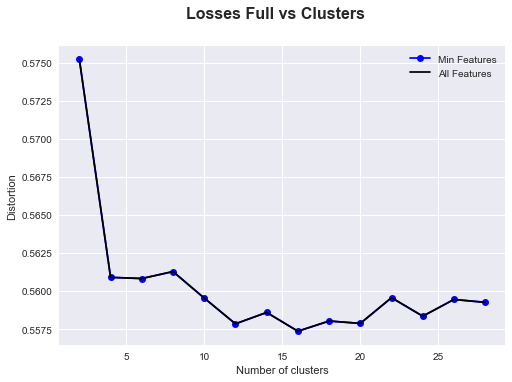

<Figure size 576x396 with 0 Axes>

In [ ]:
'''
K-Means Optimization: Clusters vs Loss
'''

# km_feature_list = ['Type','Ship_Method','Range','Item_Zip','Buyer_Zip','Category','Quantity','Size']
# linear_feature_list = ['Handle','Ship_Fee','Min','Max','Range','Dist','Weight','Price','Processing_Days']

# losses1 = []
# losses2 = []

# clusters_sizes = range(2,29,2)
# for i_num_clust in tqdm(clusters_sizes):
#     km_model, y_km = train_kmeans(df_Feat,i_num_clust,km_feature_list,all_feat = False,verbose=False)
#     linear_models = train_linears(df_Feat,i_num_clust,y_km,linear_feature_list,all_feat = False,verbose=False)
#     loss,predictions = calc_loss(df_Feat,km_model,linear_models,km_feature_list,linear_feature_list,all_feat = False,verbose=False)
#     losses1.append(loss)

#     km_model, y_km = train_kmeans(df_Feat,i_num_clust,km_feature_list,all_feat = False,verbose=False)
#     linear_models = train_linears(df_Feat,i_num_clust,y_km,linear_feature_list,all_feat = False,verbose=False)
#     loss,predictions = calc_loss(df_Feat,km_model,linear_models,km_feature_list,linear_feature_list,all_feat = False,verbose=False)
#     losses2.append(loss)

# # plot
# fig, ax1 = plt.subplots(1, 1)
# fig.suptitle('Losses Full vs Clusters',fontweight='bold',fontsize = 16)
# ax1.plot(clusters_sizes, losses1, marker='o',c='b')
# ax1.set_xlabel('Number of clusters')
# ax1.set_ylabel('Distortion')
# ax1.plot(clusters_sizes, losses2, c='k')
# ax1.legend(['Min Features','All Features'])
# plt.show()
# plt.savefig('Images/Cluster_Cts_Comparison.png')

### Not used or tried 

In [ ]:
# def my_custom_loss_func(y_true, y_pred):
#     diff = y_true - y_pred
#     early = 0.4 * abs(np.multiply(diff < 0, diff).sum())
#     late = 0.6 * np.multiply(diff > 0, diff).sum()
#     return (early + late)/max(diff.shape)

# score = make_scorer(my_custom_loss_func, greater_is_better=False)